# Milestone 1

In [1]:
from se_dataset import *
import os
from matplotlib import pyplot as plt


## Distribution of the data

### Distribution of the data by region in which the MRI was captured
![](images/region_dist.png "Region distribution")

### Distribution of the data T1/T2 mapping image type

There are 3 partitions of the data. Train, Test and Validation do not require explanation. The "mask" split is the partition which's masks are going to be used for generating fully synthetic MRI's by the diffusion model, it is neccessary for the evaluation later.

![](images/type_dist.png "Image type distribution")

In SeDataset class, partitions are hardcoded so the data is split somewhat evenly between the partitions. There are also ignored images which have unusable MRI's.

In this notebook only a part of the dataset is loaded in, although the mean and standard deviations hardcoded in the Dataset class are calculated on the whole dataset.

In [2]:
dataset = SeDataset("/mnt/f/OneDrive_2023-03-16/SE dataset/se/",
                    256,
                    classes=3,
                    type_labeling=True,
                    split='train',
                    resize=False)

Found 14283 dcm files with contours and 2235 contours files.
Found 30382 uncorrected dcm files.
Found 24853 contrast dcm files.
Couldn't identify contours file for  33331 dcm files (not including uncorrected or contrast files).
14283
Removed 362 samples from the dataset based on the IGNORED_SAMPLES list
Number of samples: 339


## Labels:

**0** - Ignore label, reserved for padding the MRI resoulution to 256x256

**1-3** - Labels for the three classes, myocardium, left ventricle and rest of MRI image of a T1-mapping MRI scan

**4-6** - Labels for the three classes, myocardium, left ventricle and rest of MRI image of a T2-mapping MRI scan

## Preprocessing of the MRI images:

The dicom images are loaded in as 12-bit images, so first theeir values have to be devided by 4095.0 to get them in the 0-1 range. Then the images are padded to 256x256 resolution, I could also resize them but it would distort them and my solution wouldn't be able to generate MRI's with realistic resoultions, their resoultion varies between regions and types. The images are then normalized by subtracting their type's mean and dividing by their standard deviation. Then the images are fit into -1 to 1 range by dividing by 2 and adding 0.5.

In the SeDataset means and standard deviations for T1 and T2 training images seperetly are hardcoded in the Dataset class. These values are calculated on the whole dataset. The images are normalized by subtracting their type's mean and dividing by their standard deviation.

The original distribution of the pixel intensities are very skewed towards the lower end of the scale, that is why these normalization steps are taken.

Cropping and horizontal flipping are also implemented in the Dataset class, but they are not used in this notebook nor will they be used in the final solution. These MRI's are very sensitive to their orientation and cropping them would make them unusable. Generally in practice, the MRI's are not cropped since they are taken of the whole heart and the flipping is not used since the MRI's are not symmetrical and usually taken in a specific orientation. (i.e. the left ventricle is always on a specific position in the image) 

In [3]:
# example dicom image pixel intensity distibution
import pydicom

image = pydicom.dcmread("/mnt/f/OneDrive_2023-03-16/SE dataset/se/2022_11_22/Patient (1)/T1_Mapping_/Apex.dcm").pixel_array


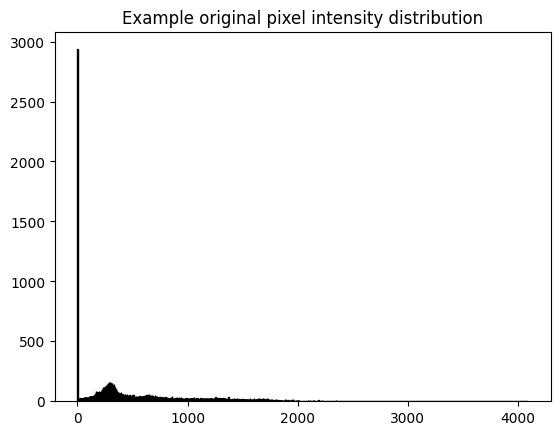

In [4]:
# plot image pixel intensity distribution
plt.hist(image.flatten(), bins=4095, range=(0, 4095), fc='k', ec='k')
plt.title('Example original pixel intensity distribution')
plt.show()

In [5]:
print("Shape of MRI image: " + str(dataset[0][0].shape))

Shape of MRI image: torch.Size([1, 256, 256])


In [6]:
print("Shape of label: " + str(dataset[0][1]["label"].shape))
# print min and max value of the mask
print("Min value of the mask: " + str(np.min(dataset[0][1]["label"].numpy())))
print("Max value of the mask: " + str(np.max(dataset[0][1]["label"].numpy())))

Shape of label: torch.Size([1, 256, 256])
Min value of the mask: 0
Max value of the mask: 3


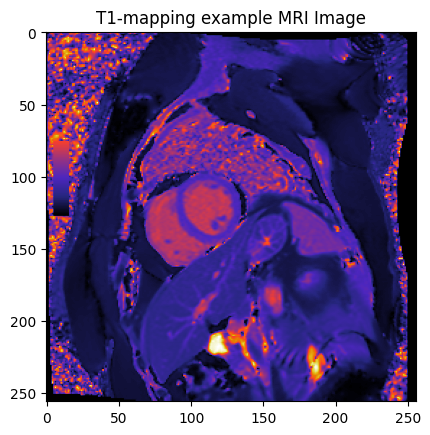

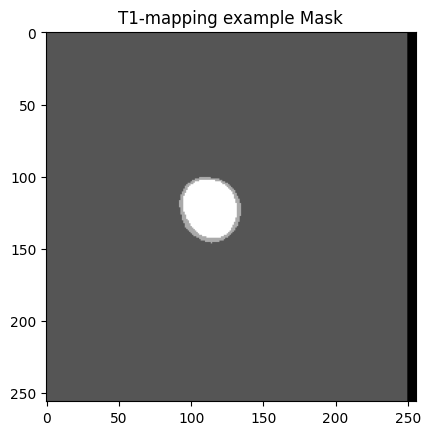

In [7]:
# Display the first image and the mask
plt.figure()
plt.imshow(dataset[0][0][0], cmap='CMRmap')
plt.title("T1-mapping example MRI Image")
plt.show()

plt.figure()
dataset[0][1]["label"][0] = dataset[0][1]["label"][0] / np.max(dataset[0][1]["label"][0].numpy())

plt.imshow(dataset[0][1]["label"][0], cmap='gray')
plt.title("T1-mapping example Mask")
plt.show()

In [8]:
print("Shape of label: " + str(dataset[1][1]["label"].shape))
# print min and max value of the mask
print("Min value of the mask: " + str(np.min(dataset[1][1]["label"].numpy())))
print("Max value of the mask: " + str(np.max(dataset[1][1]["label"].numpy())))

Shape of label: torch.Size([1, 256, 256])
Min value of the mask: 0
Max value of the mask: 6


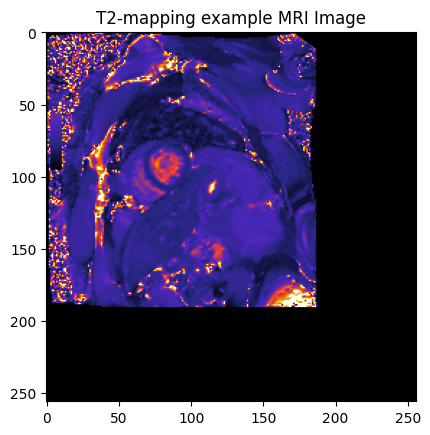

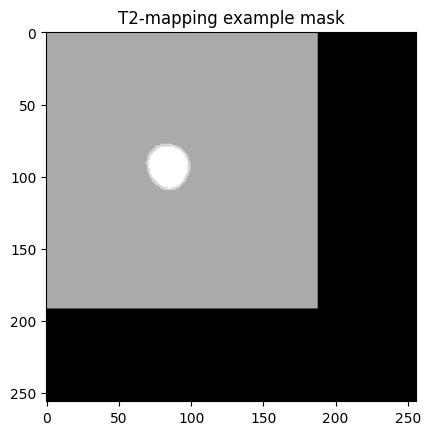

In [9]:
# display the second image and the mask
plt.figure()
plt.imshow(dataset[1][0][0], cmap='CMRmap')
plt.title("T2-mapping example MRI Image")
plt.show()

plt.figure()
dataset[1][1]["label"][0] = dataset[1][1]["label"][0] / np.max(dataset[1][1]["label"][0].numpy())

plt.imshow(dataset[1][1]["label"][0], cmap='gray')
plt.title("T2-mapping example mask")
plt.show()

## One-hot encoding of the labels

In [10]:
import torch as th

def preprocess_input(data, num_classes):
    # move to GPU and change data types
    data['label'] = data['label'].long()

    # create one-hot label map
    label_map = data['label']
    bs, _, h, w = label_map.size()
    nc = num_classes

    input_label = th.FloatTensor(bs, nc, h, w).zero_()
    input_semantics = input_label.scatter_(1, label_map, 1.0)
    

    cond = {key: value for key, value in data.items() if key not in ['label', 'path', 'label_ori', 'size_ori', 'mask_path']}
    cond['y'] = input_semantics

    return cond

In [11]:
from torch.utils.data import DataLoader
loader = DataLoader(
                dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True
            )

In [12]:
image, cond = next(iter(loader))

print(cond['label'].size())

res = preprocess_input(cond, 7)

print(res['y'].size())

torch.Size([1, 1, 256, 256])
torch.Size([1, 7, 256, 256])


In [13]:
print(res['y'])

tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 